In [52]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB, CategoricalNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier

In [40]:
filePath = '../DataBases/VlEncodedBase.pkl'
with open(filePath, 'rb') as f:
    colunas, CD4_AttributesTraining, CD4_4AttributesTest, CD4_ClassResultsTraining, CD4_ClassResultsTest = pickle.load(f)

***GridSearch***

In [48]:
param_grid = [
    {
        'estimator': [OneVsRestClassifier(MultinomialNB())],
        'estimator__estimator__alpha': np.logspace(-3, 3, 7),
        'estimator__estimator__fit_prior': [True, False]
    },
    {
        'estimator': [OneVsRestClassifier(BernoulliNB())],
        'estimator__estimator__alpha': np.logspace(-3, 3, 7),
        'estimator__estimator__fit_prior': [True, False],
        'estimator__estimator__binarize': np.linspace(0.1, 0.9, 9)
    },
    {
        'estimator': [OneVsRestClassifier(GaussianNB())],
        'estimator__estimator__var_smoothing': np.logspace(-9,-6 ,4)
    },
    {
        'estimator': [OneVsRestClassifier(ComplementNB())],
        'estimator__estimator__alpha': np.logspace(-3, 3 ,7),
        'estimator__estimator__fit_prior': [True,False],
        'estimator__estimator__norm':[True,False]
    },
    {
        'estimator': [OneVsRestClassifier(CategoricalNB())],
        'estimator__estimator__alpha': np.logspace(-3 ,3 ,7),
    }
]

In [54]:
grid_search = GridSearchCV(estimator=OneVsRestClassifier(DummyClassifier()), param_grid=param_grid, cv=5, scoring='accuracy')

In [55]:
grid_search.fit(CD4_AttributesTraining, CD4_ClassResultsTraining)

c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\multiclass.py", line 98, in _predict_binary
    score = np.ravel(estimator.decision_function(X))
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_available_if.py", line 33, in __get__
    raise attr_err
AttributeError: This 'OneVsRestClassifier' has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = s

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=DummyClassifier()),
             param_grid=[{'estimator': [OneVsRestClassifier(estimator=MultinomialNB())],
                          'estimator__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'estimator__estimator__fit_prior': [True, False]},
                         {'estimator': [OneVsRestClassifier(estimator=BernoulliNB(alpha=0...
                         {'estimator': [OneVsRestClassifier(estimator=ComplementNB())],
                          'estimator__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'estimator__estimator__fit_prior': [True, False],
                          'estimator__estimator__norm': [True, False]},
                         {'estimator': [OneVsRestClassifier(estimator=CategoricalNB())],
                          'estimator__estimator__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}],
             scoring='accuracy')

In [59]:
print("Best hyperparameters:", grid_search.best_params_)
print("Accuracy:", grid_search.best_score_)

Best hyperparameters: {'estimator': OneVsRestClassifier(estimator=BernoulliNB(alpha=0.001, binarize=0.4,
                                          fit_prior=False)), 'estimator__estimator__alpha': 0.001, 'estimator__estimator__binarize': 0.4, 'estimator__estimator__fit_prior': False}
Accuracy: 0.6833029743218745


c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


0.6549295774647887

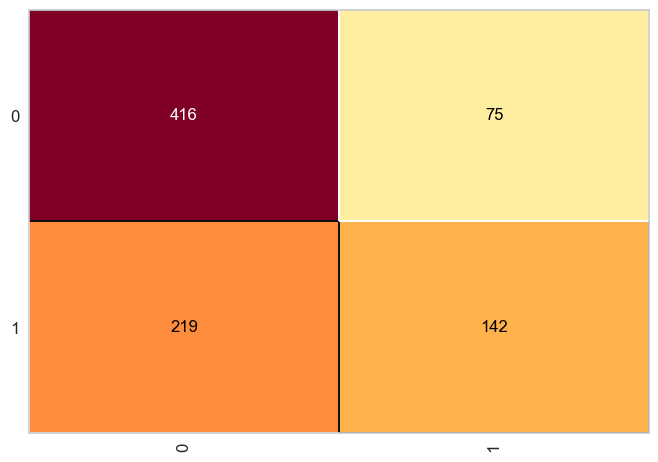

In [69]:
 # Create the base estimator with the given hyperparameters
base_estimator = BernoulliNB(alpha=0.001, binarize=0.4, fit_prior=False)

  # Create the OneVsRestClassifier with the base estima  
model = OneVsRestClassifier(estimator=BernoulliNB(alpha=0.001, binarize=0.4, fit_prior=False))
model_final = model.fit(CD4_AttributesTraining, CD4_ClassResultsTraining)

cm = ConfusionMatrix(model_final)
cm.score(CD4_4AttributesTest, CD4_ClassResultsTest)

***Criando a árvore***

In [10]:
arvore = tree.DecisionTreeClassifier(criterion= 'gini', max_depth= 2, max_features= None, splitter= 'best')

In [11]:
arvore.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2)

***Plotando a árvore***

In [ ]:
plt.subplots(figsize=(10,10))
tree.plot_tree(arvore, feature_names=colunas, class_names=arvore.classes_, filled=True)
#plt.savefig('arvore.png')

***Prevendo***

In [13]:
previsoes = arvore.predict(x_test)

In [9]:
previsoes

array(['recurrence-events', 'recurrence-events', 'no-recurrence-events',
       'recurrence-events', 'no-recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events', 'recurrence-events',
       'recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'recurrence-events', 'recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'no-recurrence

***Plotando os resultados***

In [57]:
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix

In [58]:
cm = ConfusionMatrix(arvore)
cm.score(x_test, y_test)

NameError: name 'arvore' is not defined

In [12]:
print(classification_report(y_test, previsoes,zero_division=0))

                      precision    recall  f1-score   support

no-recurrence-events       0.71      0.63      0.67        38
   recurrence-events       0.36      0.44      0.40        18

            accuracy                           0.57        56
           macro avg       0.53      0.54      0.53        56
        weighted avg       0.60      0.57      0.58        56

